# CNN 301
Slight modification of CNN 101.
Use the old code base (not imported).
Use one hot encoding, as before.
Use first 10 of each sequence class truncated to 1000 bases.
Expect overfit.

In [1]:
import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
import time

tf.keras.backend.set_floatx('float32')

EPOCHS=10
SPLITS=1
K=1
EMBED_DIMEN=16
FILENAME='CNN301'

## Load and partition sequences

In [2]:
# Assume file was preprocessed to contain one line per seq.
# Prefer Pandas dataframe but df does not support append.
# For conversion to tensor, must avoid python lists.
def load_fasta(filename,label):
    DEFLINE='>'
    labels=[]
    seqs=[]
    lens=[]
    nums=[]
    num=0
    with open (filename,'r') as infile:
        for line in infile:
            if line[0]!=DEFLINE:
                seq=line.rstrip()
                num += 1   # first seqnum is 1
                seqlen=len(seq)
                nums.append(num)
                labels.append(label)
                seqs.append(seq)
                lens.append(seqlen)
    df1=pd.DataFrame(nums,columns=['seqnum'])
    df2=pd.DataFrame(labels,columns=['class'])
    df3=pd.DataFrame(seqs,columns=['sequence'])
    df4=pd.DataFrame(lens,columns=['seqlen'])
    df=pd.concat((df1,df2,df3,df4),axis=1)
    return df

# Split into train/test stratified by sequence length.
def sizebin(df):
    return pd.cut(df["seqlen"],
                              bins=[0,1000,2000,4000,8000,16000,np.inf],
                              labels=[0,1,2,3,4,5])
def make_train_test(data):
    bin_labels= sizebin(data)
    from sklearn.model_selection import StratifiedShuffleSplit
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=37863)
    # split(x,y) expects that y is the labels. 
    # Trick: Instead of y, give it it the bin labels that we generated.
    for train_index,test_index in splitter.split(data,bin_labels):
        train_set = data.iloc[train_index]
        test_set = data.iloc[test_index]
    return (train_set,test_set)

def separate_X_and_y(data):
    y=   data[['class']].copy()
    X=   data.drop(columns=['class','seqnum','seqlen'])
    return (X,y)

def make_slice(data_set,min_len,max_len):
    print("original "+str(data_set.shape))
    too_short = data_set[ data_set['seqlen'] < min_len ].index
    no_short=data_set.drop(too_short)
    print("no short "+str(no_short.shape))
    too_long = no_short[ no_short['seqlen'] >= max_len ].index
    no_long_no_short=no_short.drop(too_long)
    print("no long, no short "+str(no_long_no_short.shape))
    return no_long_no_short


In [3]:
def make_kmer_table(K):
    npad='N'*K
    shorter_kmers=['']
    for i in range(K):
        longer_kmers=[]
        for mer in shorter_kmers:
            longer_kmers.append(mer+'A')
            longer_kmers.append(mer+'C')
            longer_kmers.append(mer+'G')
            longer_kmers.append(mer+'T')
        shorter_kmers = longer_kmers
    all_kmers = shorter_kmers
    kmer_dict = {}
    kmer_dict[npad]=0
    value=1
    for mer in all_kmers:
        kmer_dict[mer]=value
        value += 1
    return kmer_dict

KMER_TABLE=make_kmer_table(K)

def strings_to_vectors(data,uniform_len):
    all_seqs=[]
    for seq in data['sequence']:
        i=0
        seqlen=len(seq)
        kmers=[]
        while i < seqlen-K+1:
            kmer=seq[i:i+K]
            i += 1
            value=KMER_TABLE[kmer]
            kmers.append(value)
        pad_val=0
        while i < uniform_len:
            kmers.append(pad_val)
            i += 1
        all_seqs.append(kmers)
    pd2d=pd.DataFrame(all_seqs)
    return pd2d   # return 2D dataframe, uniform dimensions

In [4]:
def build_model(maxlen,dimen):
    vocabulary_size=4**K+1   # e.g. K=3 => 64 DNA K-mers + 'NNN'
    act="sigmoid"
    dt='float32'

    neurons=32
    rnn = keras.models.Sequential()
    conv1_layer = keras.layers.Conv1D(filters=64,kernel_size=3,
                activation="relu",padding="valid",input_shape=[maxlen,vocabulary_size])
    pool1_layer = keras.layers.MaxPooling1D(2)
    conv2_layer = keras.layers.Conv1D(neurons,3,activation="relu",padding="same")
    conv3_layer = keras.layers.Conv1D(neurons,3,activation="relu",padding="same")
    pool2_layer = keras.layers.MaxPooling1D(2)
    conv4_layer = keras.layers.Conv1D(neurons,3,activation="relu",padding="same")
    conv5_layer = keras.layers.Conv1D(neurons,3,activation="relu",padding="same")
    flat1_layer = keras.layers.Flatten()
    dense1_layer = keras.layers.Dense(neurons,activation=act,dtype=dt)
    drop1_layer = keras.layers.Dropout(0.5)
    dense2_layer = keras.layers.Dense(neurons,activation=act,dtype=dt)
    drop2_layer = keras.layers.Dropout(0.5)
    output_layer = keras.layers.Dense(1,activation=act,dtype=dt)

    rnn.add(conv1_layer)
    #rnn.add(pool1_layer)
    rnn.add(conv2_layer)
    #rnn.add(conv3_layer)
    rnn.add(pool2_layer)
    rnn.add(conv4_layer)
    rnn.add(conv5_layer)
    rnn.add(flat1_layer)
    rnn.add(dense1_layer)
    rnn.add(drop1_layer)
    rnn.add(dense2_layer)
    rnn.add(drop2_layer)
    rnn.add(output_layer)

    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    opt=tf.keras.optimizers.Adam(learning_rate=0.01)
    print("COMPILE")
    rnn.compile(loss=bc, optimizer=opt,metrics=["accuracy"])
    return rnn

In [5]:
def do_cross_validation(X,y,eps,maxlen,dimen):
    cv_scores = []
    fold=0
    splitter = ShuffleSplit(n_splits=SPLITS, test_size=0.2, random_state=37863)
    rnn2=None
    for train_index,valid_index in splitter.split(X):
        X_train=X[train_index] # use iloc[] for dataframe
        y_train=y[train_index]
        X_valid=X[valid_index]
        y_valid=y[valid_index]

        print("BUILD MODEL")
        rnn2=build_model(maxlen,dimen)

        print("FIT")
        start_time=time.time()
        history=rnn2.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=eps, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                validation_data=(X_valid,y_valid) )
        end_time=time.time()
        elapsed_time=(end_time-start_time)
                        
        fold += 1
        print("Fold %d, %d epochs, %d sec"%(fold,eps,elapsed_time))

        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()

        scores = rnn2.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (rnn2.metrics_names[1], scores[1]*100))
        # What are the other metrics_names?
        # Try this from Geron page 505:
        # np.mean(keras.losses.mean_squared_error(y_valid,y_pred))
        cv_scores.append(scores[1] * 100)
    print()
    print("Validation core mean %.2f%% (+/- %.2f%%)" % (np.mean(cv_scores), np.std(cv_scores)))
    return rnn2

In [6]:
def make_kmers(MINLEN,MAXLEN,train_set):
    (X_train_all,y_train_all)=separate_X_and_y(train_set)

    # The returned values are Pandas dataframes.
    # print(X_train_all.shape,y_train_all.shape)
    # (X_train_all,y_train_all)
    # y: Pandas dataframe to Python list.
    # y_train_all=y_train_all.values.tolist()
    # The sequences lengths are bounded but not uniform.
    X_train_all
    #print(type(X_train_all))
    #print(X_train_all.shape)
    #print(X_train_all.iloc[0])
    #print(len(X_train_all.iloc[0]['sequence']))

    # X: List of string to List of uniform-length ordered lists of K-mers.
    X_train_kmers=strings_to_vectors(X_train_all,MAXLEN)
    # X: true 2D array (no more lists)
    X_train_kmers.shape

    print("transform...")
    # From pandas dataframe to numpy to list to numpy
    #print(type(X_train_kmers))
    num_seqs=len(X_train_kmers)
    tmp_seqs=[]
    for i in range(num_seqs):
        kmer_sequence=X_train_kmers.iloc[i]
        tmp_seqs.append(kmer_sequence)
    X_train_kmers=np.array(tmp_seqs)
    tmp_seqs=None
    #print(type(X_train_kmers))
    #print(X_train_kmers)

    labels=y_train_all.to_numpy()
    return (X_train_kmers,labels)

In [7]:
print("Load data from files.")
#nc_seq=load_fasta('data/ncRNA.gc34.processed.fasta',0)
#pc_seq=load_fasta('data/pcRNA.gc34.processed.fasta',1)
nc_seq=load_fasta('data/ncRNA.tiny1000.fasta',0)
pc_seq=load_fasta('data/pcRNA.tiny1000.fasta',1)
all_seq=pd.concat((nc_seq,pc_seq),axis=0)

print("Put aside the test portion.")
(train_set,test_set)=make_train_test(all_seq)
# Do this later when using the test data:
# (X_test,y_test)=separate_X_and_y(test_set)

nc_seq=None
pc_seq=None
all_seq=None

print("Ready: train_set")
train_set

Load data from files.
Put aside the test portion.
Ready: train_set


,seqnum,class,sequence,seqlen
1,2,1,AGCCCAGTTGGCTGGACCAATGGATGGAGAGAATCACTCAGTGGTA...,995
4,5,1,CGCGTCCGTTAAGCCCGCGGGTCCTCCGCGAATCGGCGGTGGGTCC...,1000
7,8,0,TACGGCAGCTTTAGGGAGGTGCTCTGAGACCCGAAACTAGACTCGA...,607
1,2,0,GGGGTTTCGGGGCTGTGGACCCTGTGCCAGGAAAGGAAGGGCGCAG...,590
4,5,0,TCGGTAGCTTCCGAGGCTCTGCGGGAGAATCCGTTTCCTGGCCGTA...,821
9,10,0,ATTCAAATGGGCCCTGCTGCCAAGCCTTTTTTTTTTTTTTTAACAA...,456
8,9,0,GACTCGACTTTAACAGACACAGACGACCCTGAAGGTGAGACTGTCT...,402
3,4,1,GCTTCGGGTTGGTGTCATGGCAGCTGCGGGGAGCCGCAAGAGGCGC...,1000
2,3,1,CGCACATCCGTATCATGAAGAGAAGAGTCCACACCCACTGGGACGT...,1000
2,3,0,TCAGCCTCCCAAGTAGCTGGGGCTACAGGCACCTGCCACCAAACCC...,1000


In [8]:
def onehot(seqs):
    newX = []
    vectors=[]
    vectors.append([0,0,0,0,1])
    vectors.append([1,0,0,0,0])
    vectors.append([0,1,0,0,0])
    vectors.append([0,0,1,0,0])
    vectors.append([0,0,0,1,0])
    for seq in X_train:
        letters=[]
        for num in seq:
            hot = vectors[num]
            letters.append(hot)
        newX.append(letters)
    return np.asarray(newX)

## Len 200-1Kb


Working on full training set, slice by sequence length.
Slice size range [200 - 1000)
original (16, 4)
no short (16, 4)
no long, no short (6, 4)
Sequence to Kmer
transform...
Length of list:
6
Length of first element:
1000
First element:
[[1 0 0 0 0]
 [0 0 1 0 0]
 [0 1 0 0 0]
 ...
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 0 1]]
Compile the model
COMPILE
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 998, 64)           1024      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 998, 32)           6176      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 499, 32)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 499, 32)           3104      
______________________________________

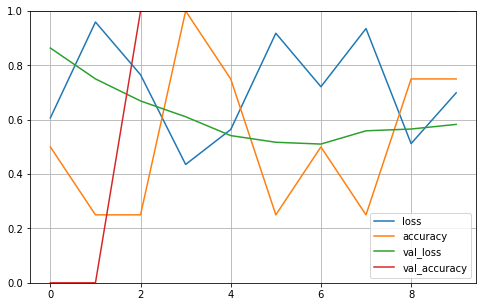

accuracy: 100.00%

Validation core mean 100.00% (+/- 0.00%)
INFO:tensorflow:Assets written to: CNN301.short.model/assets


In [9]:
MINLEN=200
MAXLEN=1000

print("Working on full training set, slice by sequence length.")
print("Slice size range [%d - %d)"%(MINLEN,MAXLEN))
subset=make_slice(train_set,MINLEN,MAXLEN)# One array to two: X and y

print ("Sequence to Kmer")
(X_train,y_train)=make_kmers(MINLEN,MAXLEN,subset)
X_train=onehot(X_train)
print("Length of list:")
print(len(X_train))
print("Length of first element:")
print(len(X_train[0]))
print("First element:")
print(X_train[0])
print ("Compile the model")
model=build_model(MAXLEN,EMBED_DIMEN)
print(model.summary())  # Print this only once
print ("Cross valiation")
model1=do_cross_validation(X_train,y_train,EPOCHS,MAXLEN,EMBED_DIMEN)
model1.save(FILENAME+'.short.model')